# Notebook to make Fig. 5: compare our posteriors with LVC posteriors

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
import h5py
from scipy.stats import gaussian_kde

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../scripts')
from helper_functions import *
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load samples

In [1]:
# Load samples from time domain analysis
td_path = data_dir+'063023_gw190521_full_NRSur7dq4_dec8_flow11_fref11_0M_TstartTend.dat'
td_samples = np.genfromtxt(td_path, names=True, dtype=float)

# Load samples from LVC frequency domain analysis
lvc_path = data_dir+'GW190521_data/GW190521_posterior_samples.h5'
with h5py.File(lvc_path, 'r') as f:
    lvc_samples = f['NRSur7dq4']['posterior_samples'][()]  
    prior_samps = f['NRSur7dq4']['priors']['samples']
    lvc_prior_samples = {k:prior_samps[k][()] for k in f['NRSur7dq4']['priors']['samples'].keys()}

In [2]:
# Format into way to plot

names = ['this work','LVC']

posteriors_to_plot = {}

for name, samples in zip(names, [td_samples, lvc_samples]):
    
    if name =='this work':
    
        mtotal = samples['mtotal']
        q = samples['q']

        m1, m2 = m1m2_from_mtotq(mtotal,q)
        
        chip = chi_precessing(m1, samples['chi1'], samples['tilt1'],
                              m2, samples['chi2'], samples['tilt2'])
        
        dL = samples['dist']
        
    else: 
        
        mtotal = samples['total_mass']
        q = samples['mass_ratio']
        dL = samples['luminosity_distance']
        chip = samples['chi_p']

    posteriors_to_plot[name] = {
        'mtotal':mtotal,
        'q':q,
        'dL':dL,
        'chip':chip
    }

### Calculate reweighting factor to go from our priors --> LVC priors

In [3]:
# Bounds 
bounds_dict = {
    'mtotal':[190,350],
    'q':[0.1,0.99],
    'dL':[1000,10000],
    'chip':[0,1]
}

# The only priors that are different are mass and luminosity distance
_, totalmass_prior_kde = reflected_kde(lvc_prior_samples['total_mass'], 
                                       *bounds_dict['mtotal'], td_samples['mtotal'])
_, q_prior_kde = reflected_kde(lvc_prior_samples['mass_ratio'], 
                               *bounds_dict['q'], td_samples['q'])
_, dL_prior_kde = reflected_kde(lvc_prior_samples['luminosity_distance'],
                                *bounds_dict['dL'], td_samples['dist'])

# Multiply them together to get the weights
weights = totalmass_prior_kde*q_prior_kde*dL_prior_kde

# Impose the total mass cutoff from LVC
lowmass = td_samples['mtotal']<350

### Make figure

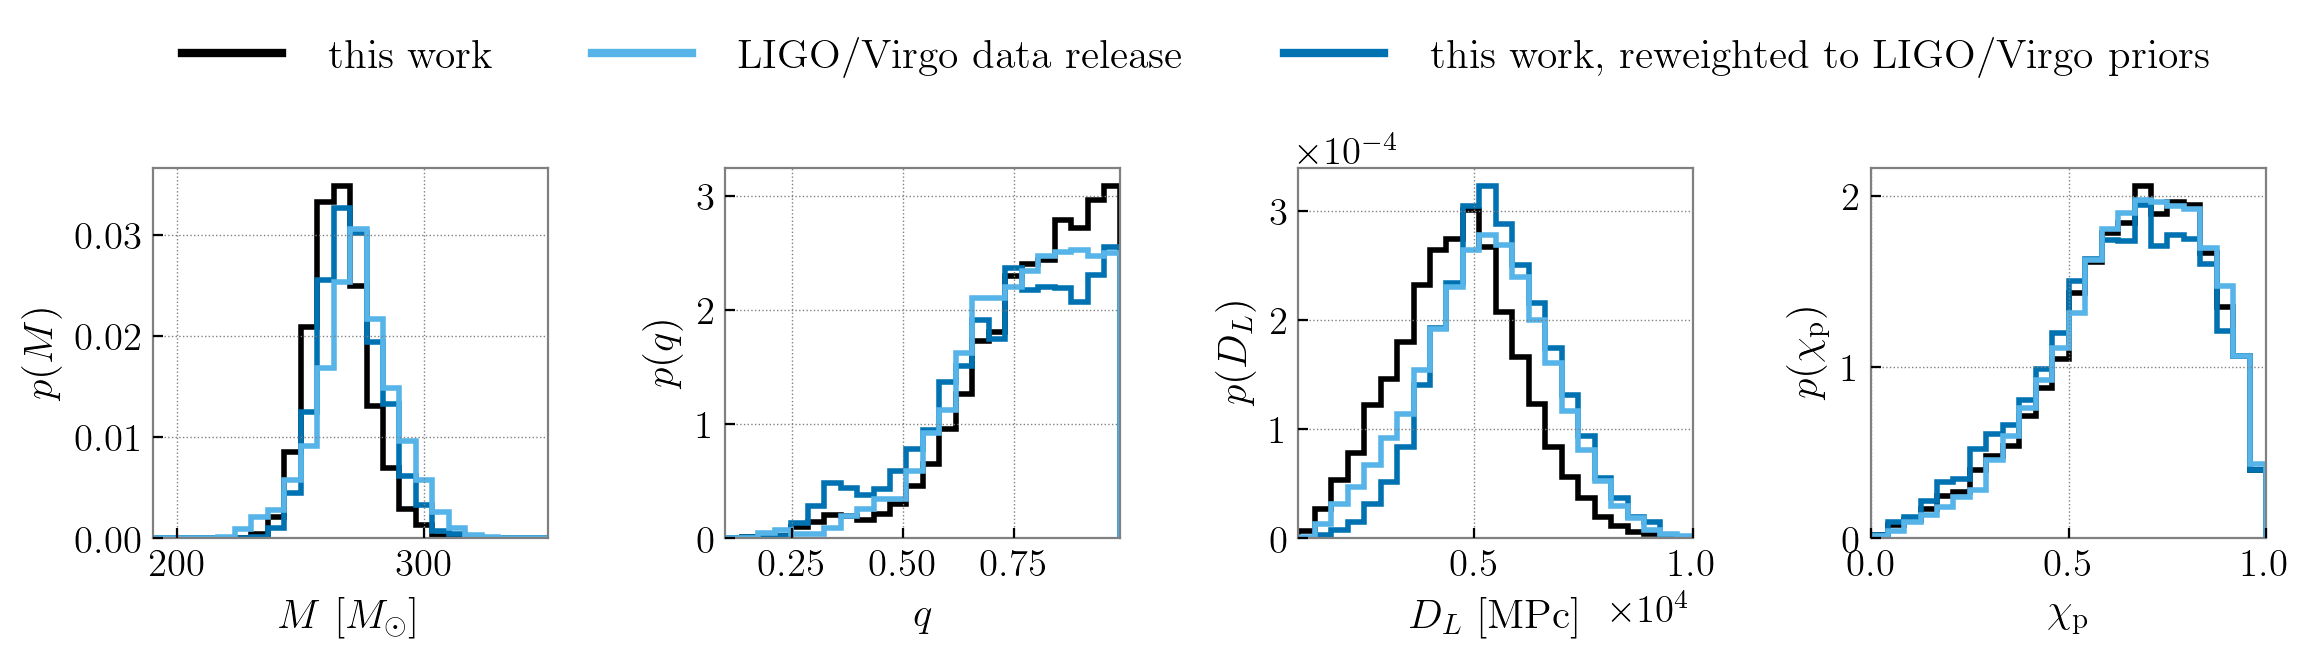

In [4]:
# Parameters 
params = ['mtotal', 'q', 'dL', 'chip']

# Labels 
labels_dict = {
    'mtotal':r'M',
    'q':r'q',
    'dL':r'D_L',
    'chip':r'\chi_\mathrm{p}'
}

# Make figure 
fig, axes = plt.subplots(1, len(params), figsize=(15/1.1, 25/8/1.3))

# Cycle through parameters
for i, param in enumerate(params): 

    nbins = 25
    bins = np.linspace(*bounds_dict[param], nbins)
    
    axes[i].hist(posteriors_to_plot['this work'][param], density=True, histtype='step', 
                 bins=bins, lw=2, color='k')
    
    axes[i].hist(posteriors_to_plot['this work'][param][lowmass], density=True, histtype='step', 
                 bins=bins, lw=2, color='#0072B2', 
                 weights=weights[lowmass])
    
    axes[i].hist(posteriors_to_plot['LVC'][param], density=True, histtype='step', 
                 bins=bins, lw=2, color='#56B4E9')
        
    label = labels_dict[param]
    if param=='mtotal':
        axes[i].set_xlabel(r'${0}~[M_\odot]$'.format(label), fontsize=15)
    elif param=='dL':
        axes[i].set_xlabel(r'${0}~[\mathrm{{MPc}}]$'.format(label), fontsize=15)
    else:
        axes[i].set_xlabel(r'${0}$'.format(label), fontsize=15)
    axes[i].set_ylabel(r'$p({0})$'.format(label), fontsize=15)
    axes[i].set_xlim(*bounds_dict[param])
    
# Legend
handles = [
    Line2D([], [], color='k', label='this work'),
    Line2D([], [], color='#56B4E9', label='LIGO/Virgo data release'), 
    Line2D([], [], color='#0072B2', label='this work, reweighted to LIGO/Virgo priors'),
]
leg = axes[0].legend(
    handles=handles, 
    bbox_to_anchor=(0.0, 1.2, 5.25, .102), loc='lower left', ncols=3, 
    mode="expand", borderaxespad=0., frameon=False, fontsize=15, handlelength=3
)
for i, h in enumerate(handles):
    leg.get_lines()[i].set_linewidth(3)

plt.subplots_adjust(wspace=0.45)
plt.savefig('figure_05.pdf', bbox_inches='tight')
plt.show()